# Lab 02 - Minimum Norm and Maximum Confidence Attacks

In this laboratory we will study a different type of attacks, namely **minimum norm** strategies.
Instead of minimizing the loss as we have seen previously, these attacks (targeted and untargeted) focus on evading the target model by finding the minimal-in-size perturbation of test-time samples.

Such can be formulated as (for untargeted attacks):

$$
\min_{\boldsymbol{\delta}} ||\boldsymbol{\delta}||_p
\\
s.t. \quad f(\boldsymbol{x}) \neq y
\\
\text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where $y$ is the original label of $\boldsymbol{x}$, $\boldsymbol{\delta}$ is the manipulation to optimize, $f$ is the model to fool.

In [1]:
try:
    import secmlt
    import sklearn
    import matplotlib
    import foolbox
except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch
    %pip install scikit-learn
    %pip install matplotlib
    %pip install foolbox

In [6]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch

from secmlt.trackers.trackers import Tracker
from secmlt.trackers.trackers import MULTI_SCALAR

class Sample2DTracker(Tracker):
    def __init__(self) -> None:
        """Create adversarial 2D sample tracker."""
        super().__init__("Sample", MULTI_SCALAR)

        self.tracked = []

    def track(
        self,
        iteration: int,
        loss: torch.Tensor,
        scores: torch.Tensor,
        x_adv: torch.Tensor,
        delta: torch.Tensor,
        grad: torch.Tensor,
    ) -> None:
        self.tracked.append(x_adv)

def secmlt_plot_attack_path(model, X, y, x_init, x_advs, epsilon, title="Attack Path on Decision Regions"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """
    import matplotlib.pyplot as plt

    x_advs = x_advs.T.squeeze().numpy()
    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)
    
    # Concatenate the initial point to the attack path
    path = np.vstack([x_init_np, x_advs])
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(path[0,0], path[0,1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_attack_path(model, X, y, x_init, deltas, epsilon, title="Attack Path on Decision Regions"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """

    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)

    # Compute attack path: x_init + deltas (assume deltas shape [2, N])
    if deltas.shape[0] == 2:
        path = x_init_np.reshape(2, 1) + deltas.detach().cpu().numpy()
        path = path.T
    else:
        path = x_init_np + deltas.detach().cpu().numpy()
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(x_init_np[0], x_init_np[1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

X_train, y_train = make_blobs(n_samples=500, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=100)
secmlt_model = BasePytorchClassifier(model, trainer=trainer)
secmlt_model.train(tr_dataloader)

Net(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

We can now write a simple minimum-norm attack, similarly to what we did for the Projected Gradient Descent.
However, here we do not have to project the perturbation inside a specific budget, but we only need to stop when the computed perturbation evades the classifier.

In [7]:
import torch
def untargeted_l2_min_norm(model, x, y, alpha=0.01, max_iter=200, lb=-1, ub=1):
    """
    Perform untargeted PGD attack on an input sample.  
    Parameters:
        model: The neural network model to attack.
        x: The input sample to be perturbed (torch tensor).
        y: The true label of the input sample (torch tensor).
        alpha: The step size for each iteration.
        max_iter: Maximum number of iterations.
    Returns:
        x_adv: The adversarially perturbed sample (torch tensor).
    """
    model.eval()
    delta = torch.zeros_like(x, requires_grad=True)
    deltas = []
    for _ in range(max_iter):
        outputs = model(x + delta)
        if outputs.argmax(dim=-1) != y:
            break
        loss = torch.nn.CrossEntropyLoss()(outputs, y)
        loss.backward()

        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)

        delta.data = delta + alpha * gradient
        
        delta.data = torch.clamp(delta.data, lb - x, ub - x)

        deltas.append(delta.data)
        
        delta.grad.zero_()
    deltas = torch.vstack(deltas)
    return x.data + delta.data, deltas

Predicted label: 0 
Real label: 2


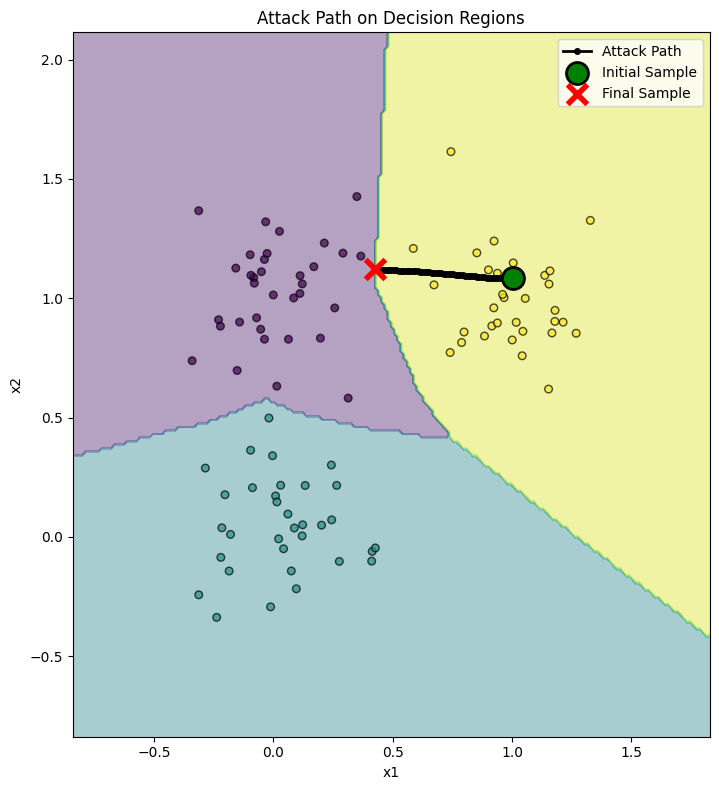

In [14]:
# we execute the attack on a single sample
alpha = 1e-2
num_iter=500

x_advs, deltas = untargeted_l2_min_norm(model, X_test[0,:], y_test[0], alpha=alpha, max_iter=num_iter, lb=-2, ub=2)
y_pred = model(x_advs).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:",y_test[0].item())
plot_attack_path(model, X_test, y_test, X_test[0,:], deltas, None, title="Attack Path on Decision Regions")

## Exercise 1

* Create the targeted version of this attack, by changing the code accordingly.
* Can minimum-norm attacks fail? Should minimum-norm attacks fail?


## Minimum-norm attacks with SecML Torch

The library already contains implementations of these kind of attacks, we will use Fast Minimum Norm CITE.

Predicted label: 0 
Real label: 2


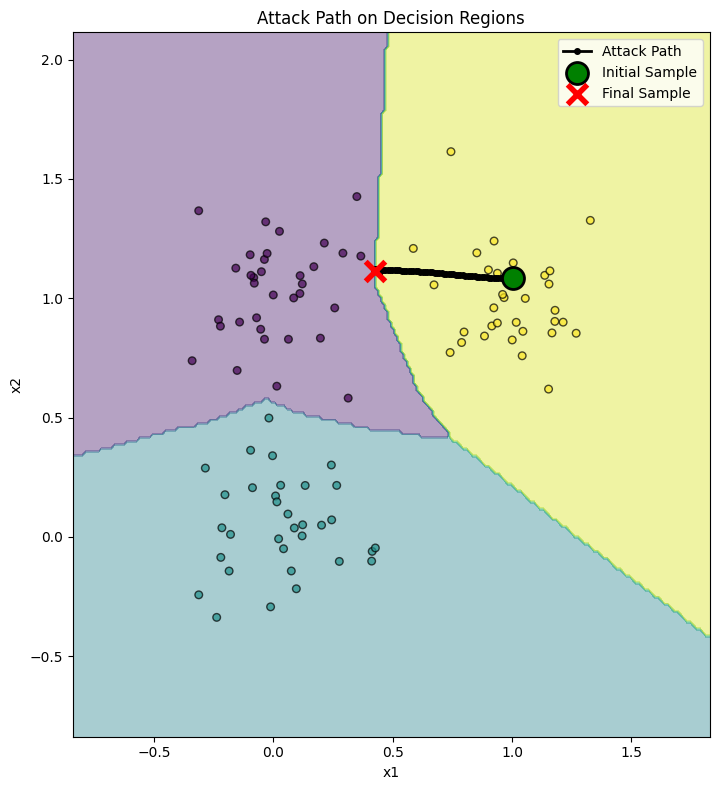

In [15]:
from secmlt.adv.evasion.fmn import FMN
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

path_tracker = Sample2DTracker()
alpha = 1e-2
num_iter=500
perturbation_model = LpPerturbationModels.L2

single_sample_loader = DataLoader(TensorDataset(X_test[0:1,:], y_test[0:1]), batch_size=1, shuffle=False)
fmn_attack = FMN(
    perturbation_model=perturbation_model,
    num_steps=num_iter,
    step_size=alpha,
    y_target=None,
    lb=-2,
    ub=2,
    backend = Backends.NATIVE,
    trackers=[path_tracker]
)

adv_dataloader = fmn_attack(secmlt_model, single_sample_loader)
x_adv = adv_dataloader.dataset[0][0]
y_pred = model(x_adv).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:",y_test[0].item())
secmlt_plot_attack_path(secmlt_model.model, X_test, y_test, X_test[0,:], path_tracker.get(), None, title="Attack Path on Decision Regions")